### Datasets
1. Car registration: Passenger cars for the European Union
2. Ted Spread Spread
3. Election Results from 1952 to 2016

In [1]:
import pandas as pd
import numpy as np

columns = ['Year','Incumbent Party Candidate','Other Candidate','Incumbent Party Vote Share']

data = [[1952,"Stevenson","Eisenhower",44.6],
        [1956,"Eisenhower","Stevenson",57.76],
        [1960,"Nixon","Kennedy",49.91],
        [1964,"Johnson","Goldwater",61.34],
        [1968,"Humphrey","Nixon",49.60],
        [1972,"Nixon","McGovern",61.79],
        [1976,"Ford","Carter",48.95],
        [1980,"Carter","Reagan",44.70],
        [1984,"Reagan","Mondale",59.17],
        [1988,"Bush, Sr.","Dukakis",53.94],
        [1992,"Bush, Sr.","Clinton",46.55],
        [1996,"Clinton","Dole",54.74],
        [2000,"Gore","Bush, Jr.",50.27],
        [2004,"Bush, Jr.","Kerry",51.24],
        [2008,"McCain","Obama",46.32],
        [2012,"Obama","Romney",52.00], 
        [2016,"Clinton","Trump",48.2]]
        
votes = pd.DataFrame(data=data, columns=columns)

In [2]:
car_reg = pd.read_csv('car_registration_europe.csv')

In [3]:
ted = pd.read_csv('ted_rate.csv')

### Wrangling

In [5]:
# since election day is early nov. we'll take the average of the last 
# three months of car registration and Ted Spread rate 

In [6]:
car_reg['DATE'] = pd.to_datetime(car_reg['DATE'])
ted['DATE'] = pd.to_datetime(ted['DATE'])

In [7]:
ted['Ted Spread'] = ted['TEDRATE'].replace('.', np.nan)
ted['Ted Spread'] = pd.to_numeric(ted['Ted Spread'])

In [8]:
car_reg['Car Growth'] = pd.to_numeric(car_reg['EU28SLRTCR03GPSAM'])
car_reg = car_reg.drop('EU28SLRTCR03GPSAM',axis=1)

In [9]:
grouped = ted.groupby(by=[ted['DATE'].dt.year,ted['DATE'].dt.month]).mean()
g = pd.merge(grouped.xs(8,level=1),grouped.xs(9,level=1),left_index=True,right_index=True)
g = pd.merge(g,grouped.xs(10,level=1),left_index=True,right_index=True)

In [10]:
g = g.mean(axis=1)

In [13]:
ted = pd.DataFrame(g).reset_index()
car_reg = car_reg.groupby(by=car_reg['DATE'].dt.year).mean().reset_index()

In [15]:
df = pd.merge(ted,car_reg,on='DATE')
df.columns = ['date','Ted Spread','Car Growth']
df = df.loc[df['date'].isin(votes['Year'])]

In [18]:
votes = votes.loc[votes['Year'] >= 1988]

In [19]:
df = df.merge(votes,left_on='date',right_on='Year')

## Predicting

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [40]:
X = df[['Ted Spread','Car Growth']]
y = df['Incumbent Party Vote Share']

In [25]:
model = LinearRegression()

In [26]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
y_pred = model.predict(X)

In [28]:
y_pred

array([49.11294104, 50.00125869, 50.81277993, 50.58156629, 51.18686652,
       48.88328618, 52.03717449, 50.64412687])

In [29]:
error = mean_absolute_error(y,y_pred)

## Baseline

In [30]:
df['mean_baseline'] = df['Incumbent Party Vote Share'].mean()

In [31]:
mean_absolute_error(df['Incumbent Party Vote Share'],df['mean_baseline'])

2.5725

## 2d Visual

In [32]:
import matplotlib.pyplot as plt

In [33]:
df['y_pred'] = y_pred

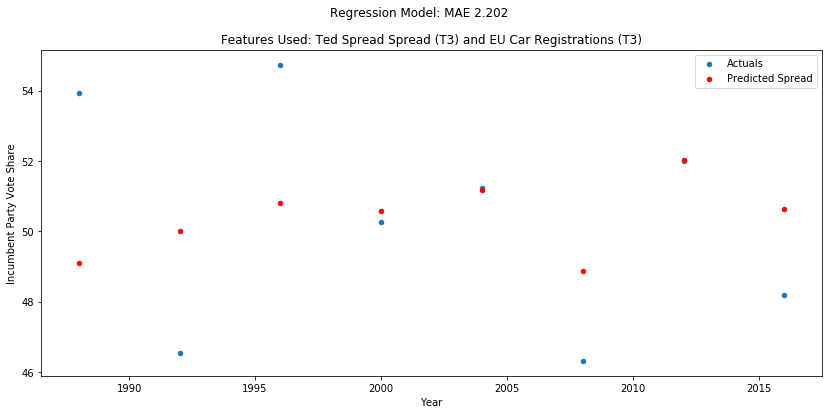

In [39]:
%matplotlib inline
ax = df.plot(x='date',y='Incumbent Party Vote Share',kind='scatter',figsize=(14,6))
df.plot(x='date',y='y_pred',kind='scatter',ax=ax,color='red')
plt.legend(['Actuals','Predicted Spread'])
plt.title('Features Used: Ted Spread Spread (T3) and EU Car Registrations (T3)')
plt.suptitle('Regression Model: MAE {}'.format(round(error,3)))
plt.xlabel('Year')
plt.ylabel('Incumbent Party Vote Share');


## 3d Visual

In [ ]:
x1 = np.linspace(df['Ted Spread'].min(), df['Ted Spread'].max())
x2 = np.linspace(df['Car Growth'].min(),df['Car Growth'].max())
X1, X2 = np.meshgrid(x1, x2)

In [ ]:
X = np.c_[X1.flatten(), X2.flatten()]

In [ ]:
preds = model.predict(X)
preds = preds.reshape(50,50)

<IPython.core.display.Javascript object>


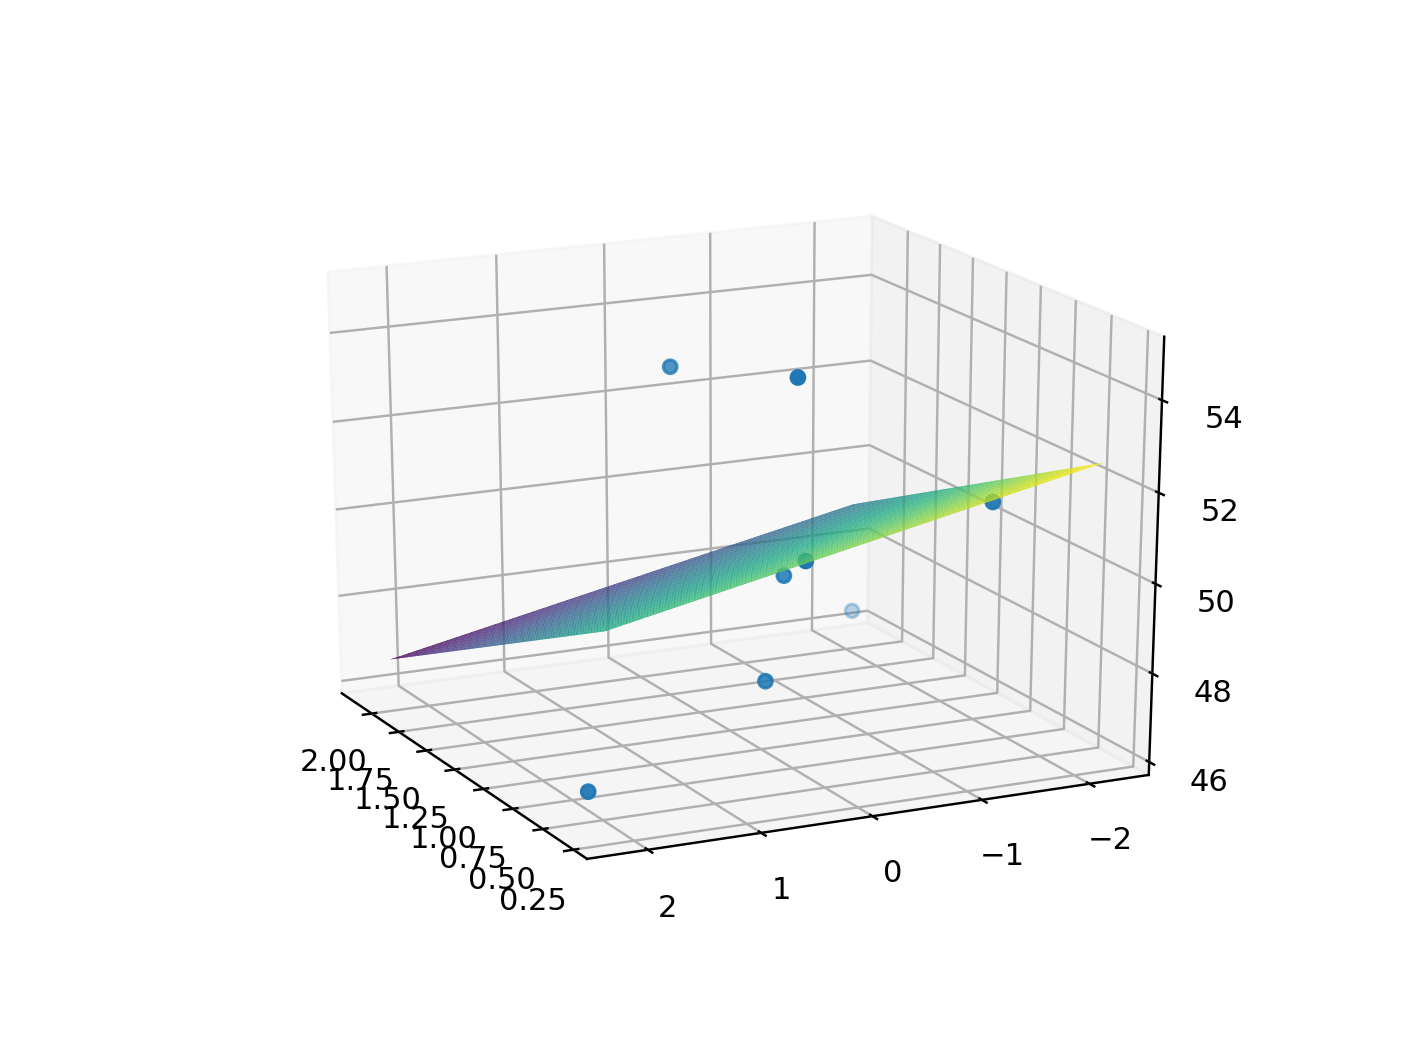

In [124]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['Ted Spread'],df['Car Growth'],df['Incumbent Party Vote Share'])
ax.plot_surface(X1, X2, preds, cmap='viridis')
